# **EDA for cursor_position variable**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# ploting
import matplotlib.pyplot as plt
# model initial:
import statsmodels.api as sm

In [2]:
#Set import folder
input_folder = "kaggle/input/linking-writing-processes-to-writing-quality/"

In [3]:
# Load train logs
train_logs = pd.read_csv(input_folder + "train_logs.csv",delimiter = ",",header = 0)
# Set the id and event id as index:
train_logs_indexed = train_logs.set_index(['id', 'event_id'])
# Load train scores
train_scores = pd.read_csv(input_folder +"train_scores.csv", delimiter = ",", header = 0)
scores = pd.Series(data = train_scores['score'].values, index = train_scores['id'].values, name = 'score')

In [4]:
train_logs.head(4)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1


In [5]:
train_logs.shape

(8405898, 11)

In [6]:
train_logs.cursor_position.describe()

count    8.405898e+06
mean     1.222964e+03
std      9.485242e+02
min      0.000000e+00
25%      4.990000e+02
50%      1.043000e+03
75%      1.706000e+03
max      7.802000e+03
Name: cursor_position, dtype: float64

In [7]:
score_60 = scores[scores == 6.0].index.values
score_05 = scores[scores == 0.5].index.values
score_30 = scores[scores == 3.0].index.values


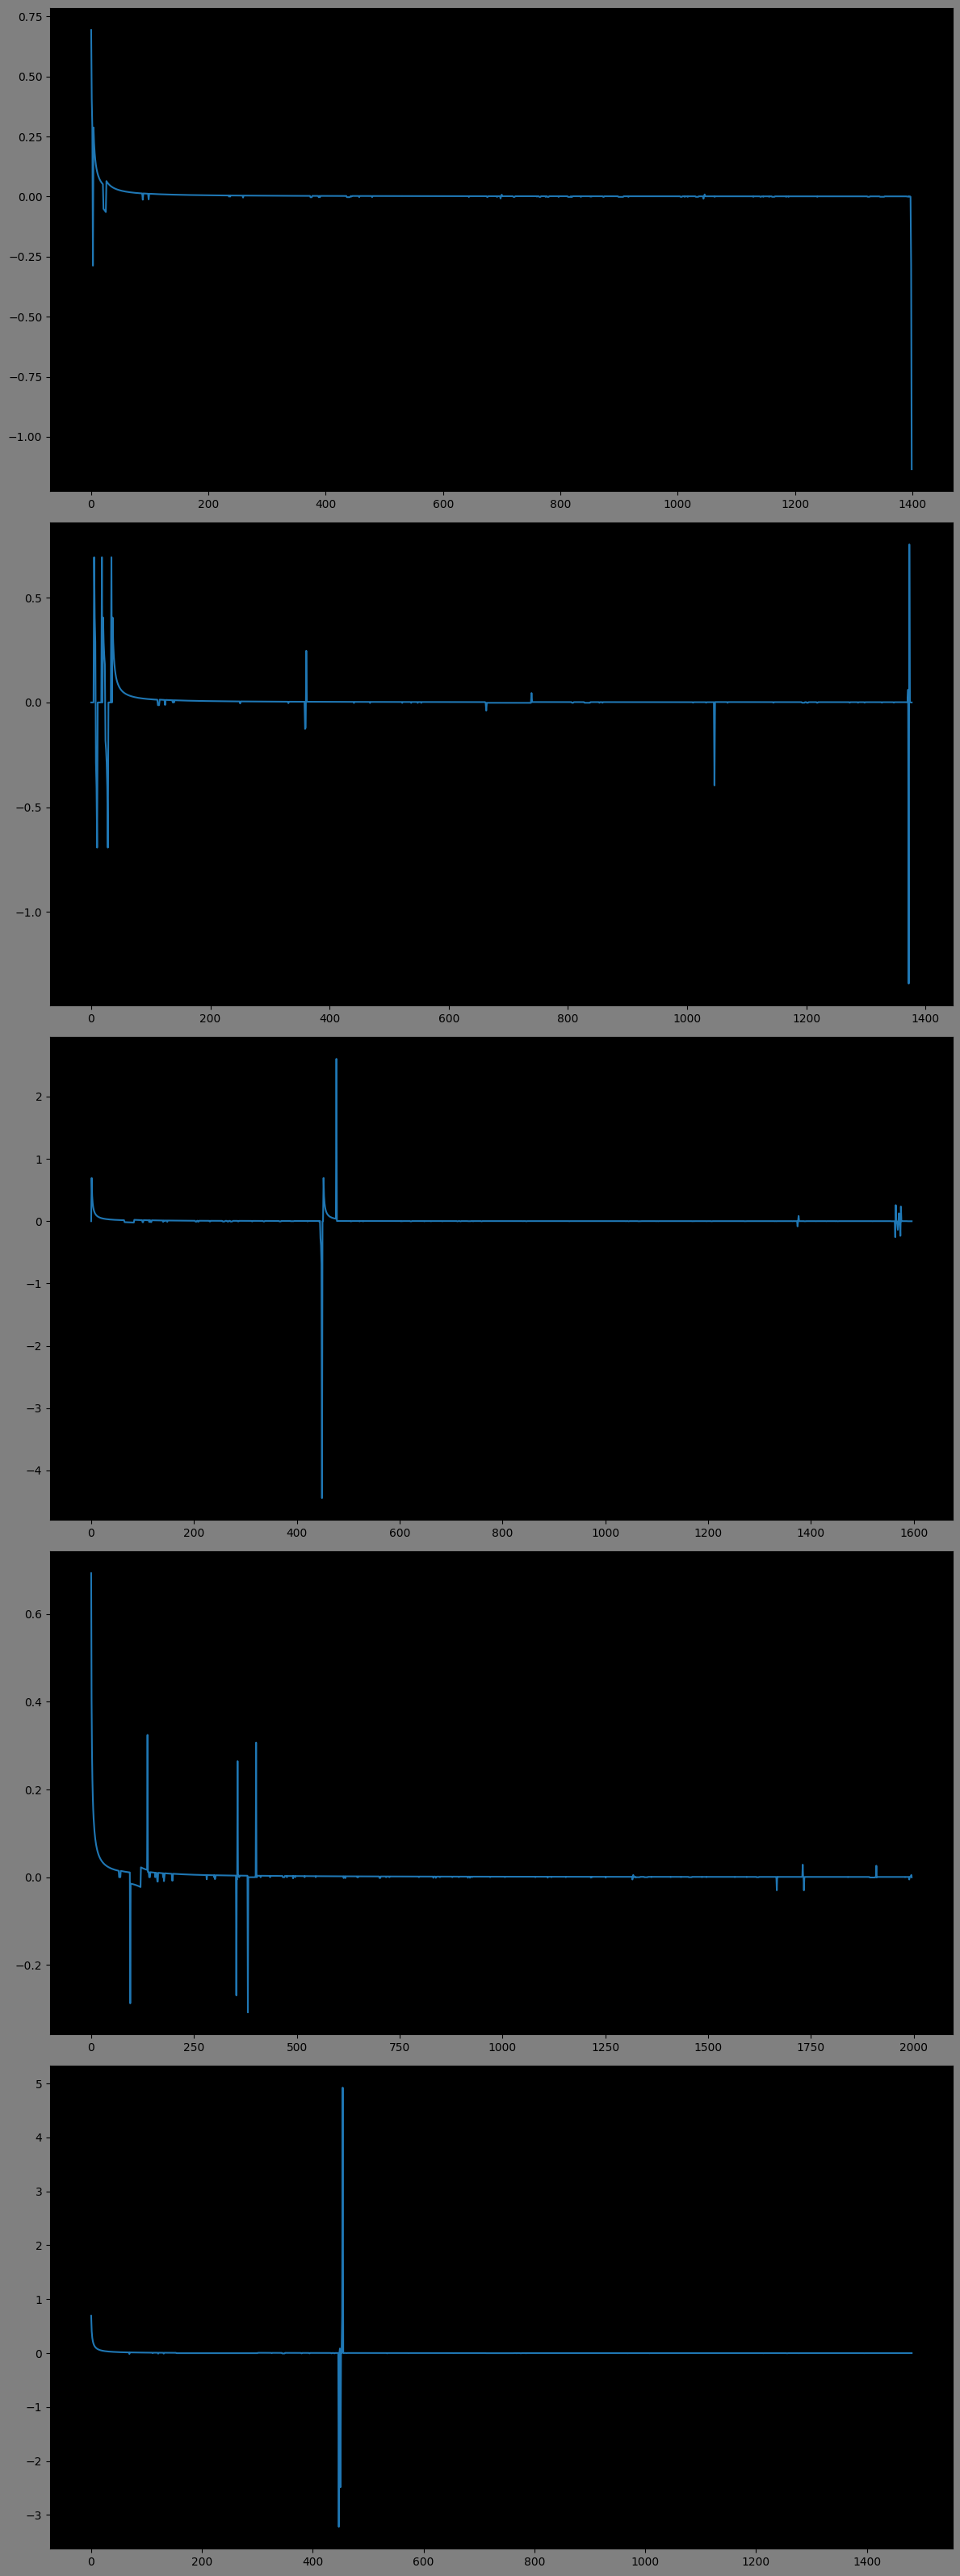

In [8]:
graph_n = 5 
fig, ax = plt.subplots(nrows = graph_n, figsize = (12, 32))
fig.set_facecolor('gray')
for i in range(graph_n):
    wc = train_logs_indexed.loc[score_05[i]].cursor_position.agg(lambda x: np.diff(np.log(x+1))) 
    ax[i].plot(np.arange(0,wc.shape[0]), wc)
    ax[i].set_facecolor('black')
fig.tight_layout()
plt.show()

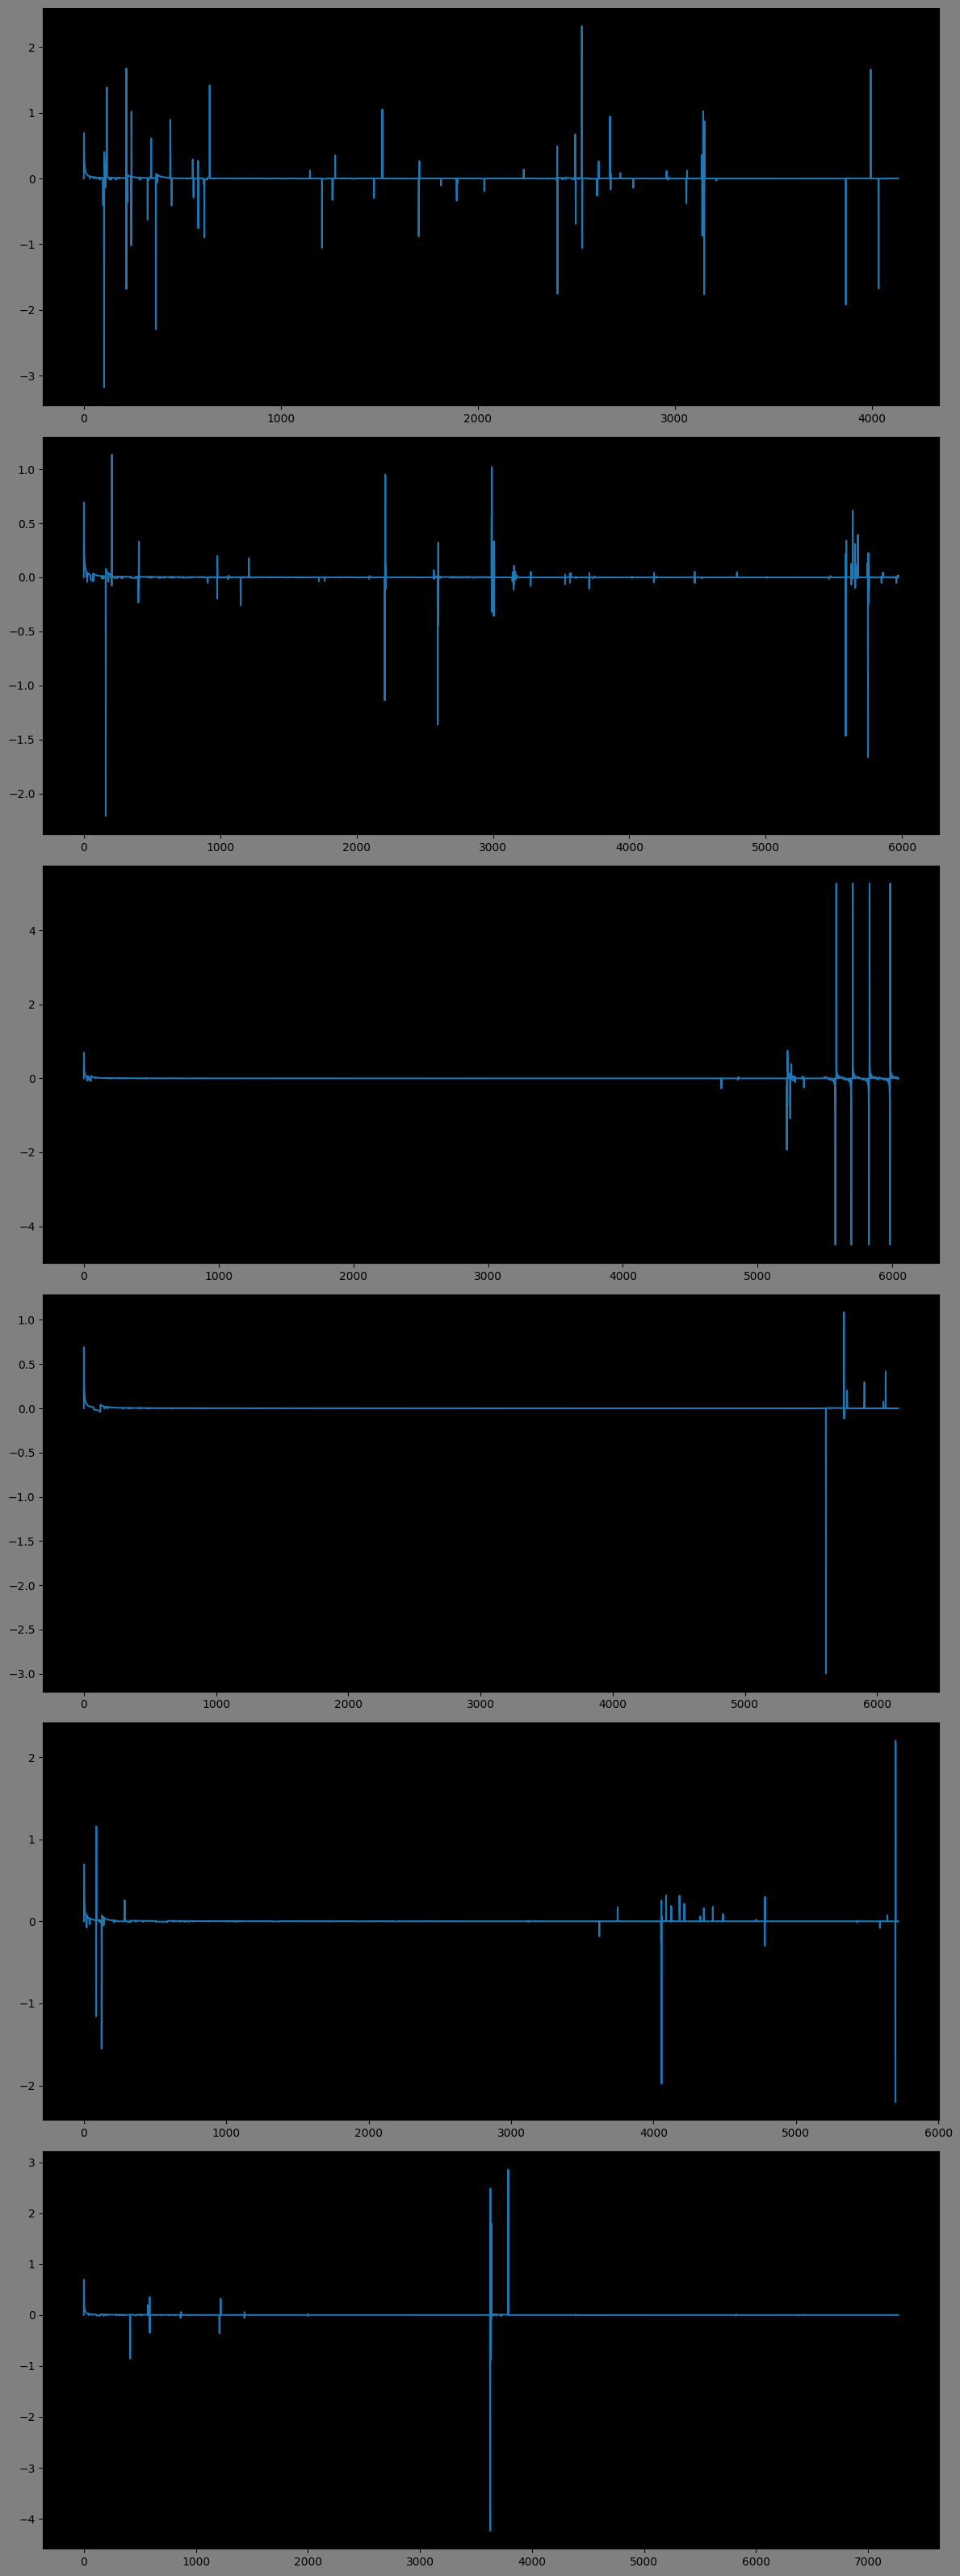

In [9]:
graph_n = 6 
fig, ax = plt.subplots(nrows = graph_n, figsize = (12, 32))
for i in range(graph_n):
    wc = train_logs_indexed.loc[score_60[i]].cursor_position.agg(lambda x: np.diff(np.log(x+1))) 
    wc = train_logs_indexed.loc[score_60[i]].cursor_position.agg(lambda x: np.diff(np.log(x+1))) 
    ax[i].plot(np.arange(0,wc.shape[0]), wc)
    ax[i].set_facecolor('black')
fig.tight_layout()
fig.set_facecolor('grey')
plt.show()

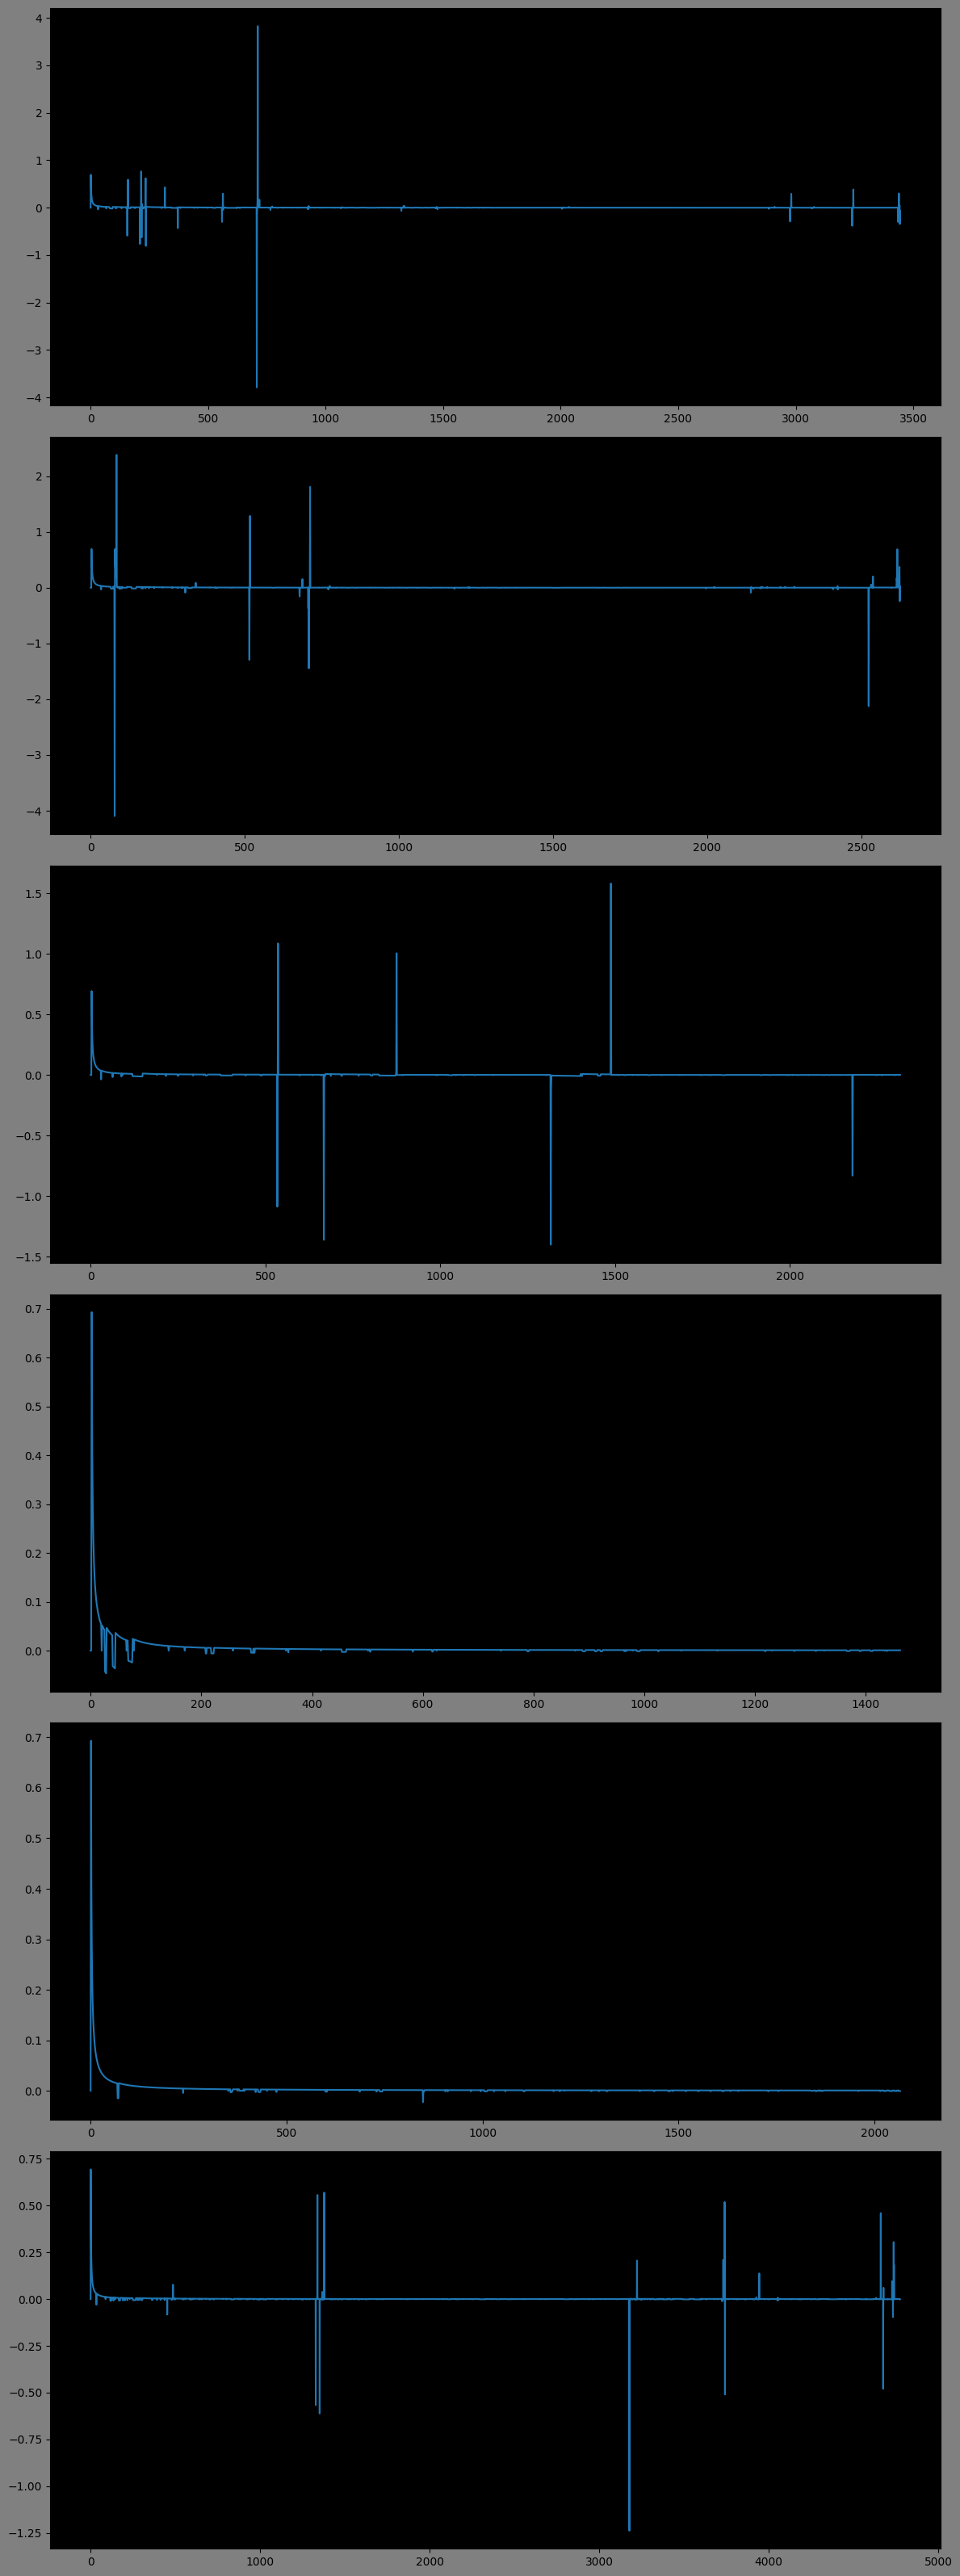

In [10]:
graph_n = 6 
fig, ax = plt.subplots(nrows = graph_n, figsize = (12, 32))
for i in range(graph_n):
    wc = train_logs_indexed.loc[score_30[i]].cursor_position.agg(lambda x: np.diff(np.log(x+1))) 
    wc = train_logs_indexed.loc[score_30[i]].cursor_position.agg(lambda x: np.diff(np.log(x+1))) 
    ax[i].plot(np.arange(0,wc.shape[0]), wc)
    ax[i].set_facecolor('black')
fig.tight_layout()
fig.set_facecolor('grey')
plt.show()

In [11]:
# cursor_position feature engineering
# here, we see that we need to get how many times does the person go back and what is the maginitude or
# how far does he/she went back?

# jan 6. added average cursor position.

def cp_sum_backstep(x):
    n1 = np.diff(np.log(x+1))
    return np.sum(n1[n1 < 0])

def cp_skew_backstep(x):
    n1 = np.diff(np.log(x+1))
    return st.skew(n1[n1 < 0])

def cp_n_backstep(x):
    n1 = np.diff(np.log(x+1))
    return np.log((n1<0).sum())

def cp_sum_forwardstep(x):
    n1 = np.diff(np.log(x+1))
    return np.sum(n1[n1 > 0])

def cp_skew_forwardstep(x):
    n1 = np.diff(np.log(x+1))
    return st.skew(n1[n1 > 0])

def cp_n_forwardstep(x):
    n1 = np.diff(np.log(x+1))
    return np.log((n1>0).sum())

def cp_change_stat(x):
    n1 = np.diff(np.log(x+1))
    return np.mean(n1)

    
    
cp = train_logs.groupby('id')['cursor_position'].aggregate([cp_sum_backstep,cp_n_backstep, 
                                                            cp_sum_forwardstep, cp_n_forwardstep,
                                                           cp_change_stat,cp_skew_backstep, 
                                                            cp_skew_forwardstep, lambda x: np.log(np.mean(x))])
cp.columns =['cp_sum_backstep', 'cp_n_backstep', 'cp_sum_forwardstep','cp_n_forwardstep',
             'cp_change_stat', 'cp_skew_backstep', 'cp_skew_forwardstep', 'average']
#testing:
cp.head(3)




,cp_sum_backstep,cp_n_backstep,cp_sum_forwardstep,cp_n_forwardstep,cp_change_stat,cp_skew_backstep,cp_skew_forwardstep,average
id,,,,,,,,
001519c8,-17.033012,6.118097,23.986697,7.631917,0.002721,-12.809379,16.882931,6.566902
0022f953,-17.209967,5.799093,24.536433,7.612337,0.002987,-6.949562,13.822311,6.654418
0042269b,-32.798866,6.177944,38.997345,8.175829,0.001499,-6.193762,16.609002,6.595250


In [12]:
z = pd.merge(cp, scores, left_index = True, right_index = True)
z.corr()

,cp_sum_backstep,cp_n_backstep,cp_sum_forwardstep,cp_n_forwardstep,cp_change_stat,cp_skew_backstep,cp_skew_forwardstep,average,score
cp_sum_backstep,1.000000,-0.267939,-0.998984,-0.132360,0.197215,-0.030518,0.022691,0.038227,-0.018364
cp_n_backstep,-0.267939,1.000000,0.277911,0.672353,-0.736609,-0.671192,0.251515,0.409494,0.386854
cp_sum_forwardstep,-0.998984,0.277911,1.000000,0.151386,-0.204426,0.021012,-0.013329,-0.018257,0.032028
cp_n_forwardstep,-0.132360,0.672353,0.151386,1.000000,-0.881759,-0.524613,0.468763,0.882034,0.684374
cp_change_stat,0.197215,-0.736609,-0.204426,-0.881759,1.000000,0.507639,-0.376109,-0.720873,-0.599220
cp_skew_backstep,-0.030518,-0.671192,0.021012,-0.524613,0.507639,1.000000,-0.541942,-0.395403,-0.313955
cp_skew_forwardstep,0.022691,0.251515,-0.013329,0.468763,-0.376109,-0.541942,1.000000,0.474114,0.336884
average,0.038227,0.409494,-0.018257,0.882034,-0.720873,-0.395403,0.474114,1.000000,0.666851
score,-0.018364,0.386854,0.032028,0.684374,-0.599220,-0.313955,0.336884,0.666851,1.000000


In [13]:
# cp2 eda 2 cursor position:
# chi-square distribution:
